# Run Generic Automated EAS tests
This is a starting-point notebook for running tests from the generic EAS suite in `tests/eas/generic.py`. The test classes that are imported here provide helper methods to aid analysis of the cause of failure. You can use Python's `help` built-in to find those methods (or you can just read the docstrings in the code).

These tests make estimation of the energy efficiency of task placements, without directly examining the behaviour of cpufreq or cpuidle. Several test classes are provided, the only difference between them being the workload that is used.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
from conf import LisaLogging
LisaLogging.setup()#level=logging.WARNING)

import pandas as pd

from perf_analysis import PerfAnalysis

import trappy
from trappy import ILinePlot
from trappy.stats.grammar import Parser

2017-03-06 15:27:20,990 INFO    : root         : Using LISA logging configuration:
2017-03-06 15:27:20,993 INFO    : root         :   /home/brendan/sources/lisa/logging.conf


## Run test workload

If you simply want to run all the tests and get pass/fail results, use this command in the LISA shell: `lisa-test tests/eas/generic.py`. This notebook is intended as a starting point for analysing what scheduler behaviour was judged to be faulty.

Target configuration is taken from `$LISA_HOME/target.config` - you'll need to edit that file to provide connection details for the target you want to test.

In [2]:
from tests.eas.generic import TwoBigTasks, TwoBigThreeSmall, RampUp, RampDown, EnergyModelWakeMigration, OneSmallTask

By default we'll run the EnergyModelWakeMigration test, which runs a workload alternating between high and low-intensity. All the other test classes shown above have the same interface, but run different workloads. To run the tests on different workloads, change this line below:

In [3]:
t = EnergyModelWakeMigration()
print t.__doc__


    Test EAS for tasks alternating beetween 10% and 50%
    


In [4]:
t.setUpClass()

2017-03-06 15:27:23,108 INFO    : LisaTest     : Setup tests execution engine...
2017-03-06 15:27:23,113 INFO    : TestEnv      : Using base path: /home/brendan/sources/lisa
2017-03-06 15:27:23,129 INFO    : TestEnv      : Loading default (file) target configuration
2017-03-06 15:27:23,135 INFO    : TestEnv      : Loading target configuration [/home/brendan/sources/lisa/target.config]...
2017-03-06 15:27:23,148 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-03-06 15:27:23,156 INFO    : TestEnv      : External tools using:
2017-03-06 15:27:23,159 INFO    : TestEnv      :    ANDROID_HOME: /opt/android-sdk-linux/
2017-03-06 15:27:23,163 INFO    : TestEnv      :    CATAPULT_HOME: /home/brendan/sources/lisa/tools/catapult
2017-03-06 15:27:23,166 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'cgroups']
2017-03-06 15:27:23,182 INFO    : TestEnv      : Connecting Android target [FA6A10305167]
2017-03-06 15:27:23,192 INFO    : TestEnv      : Connec

In [5]:
experiment = t.executor.experiments[0]

## Examine trace



`get_power_df` and `get_expected_power_df` look at the ftrace results from the workload estimation and judge the energy efficiency of the system, considering *only task placement* (assuming perfect load-tracking/prediction, cpuidle, and cpufreq systems). The energy estimation doesn't take every single wakeup and idle period into account, but simply estimates an average power usage over the time that each task spent attached to each CPU during each phase of the rt-app workload.

These return DataFrames estimating the energy usage of the system under each task placement. `estimated_power` will represent this estimation for the scheduling pattern that we actually observed, while `expected_power` will represent our estimation of how much power an **optimal** scheduling pattern would use.

Check the docstrings for these functions (and other functions in the test class) for more detail.

In [6]:
# print t.get_power_df.__doc__
estimated_power = t.get_power_df(experiment)

2017-03-06 15:27:58,281 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2017-03-06 15:27:59,786 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [7]:
# print t.get_expected_power_df.__doc__
expected_power = t.get_expected_power_df(experiment)

### Show the utilisation of the workload tasks over time

In [8]:
ex = t.experiments[0]
tu = t.get_task_utils_df(t.experiments[0])

ILinePlot(tu, column=tu.columns.tolist(), drawstyle='steps-post').view()
tu

""
""


,task_wmig_0,task_wmig_1
0.213061,102.4,102.4
2.213061,716.8,716.8
4.213061,102.4,102.4
6.213061,716.8,716.8
8.213061,0.0,0.0


##  Plot the estimated optimal work distribution for each phase of the workload

In [9]:
nrg_model = t.te.nrg_model

In [10]:
def examine_phase(n):
    # [row.to_dict() for time, row in tu.iterrows()]
    phase0 = tu.iloc[n].to_dict()
    placements = nrg_model.get_optimal_placements(phase0)
    for placement in placements:
        pd.DataFrame(list(placement)).plot(kind='bar')

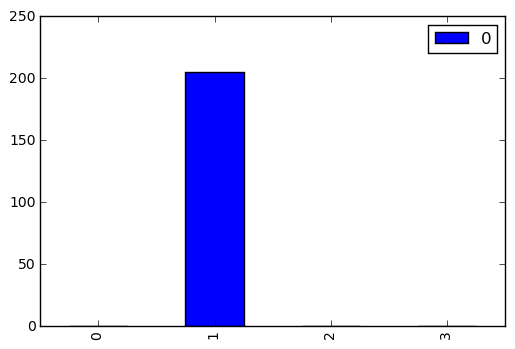

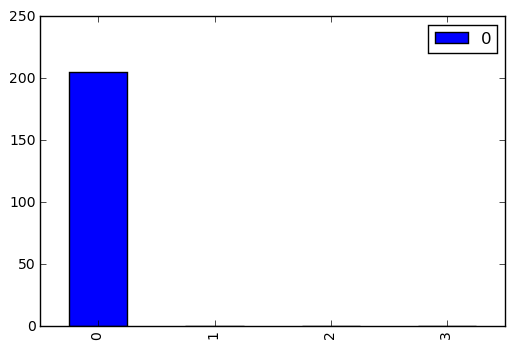

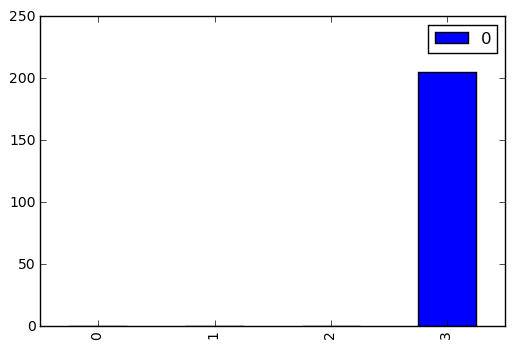

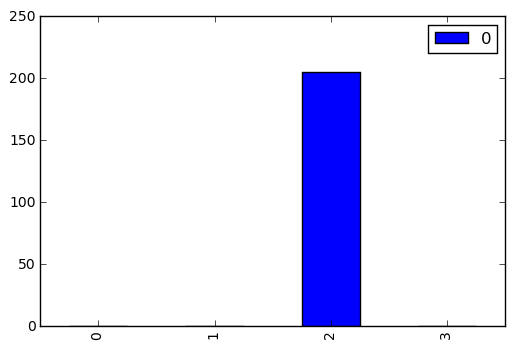

In [11]:
examine_phase(0)

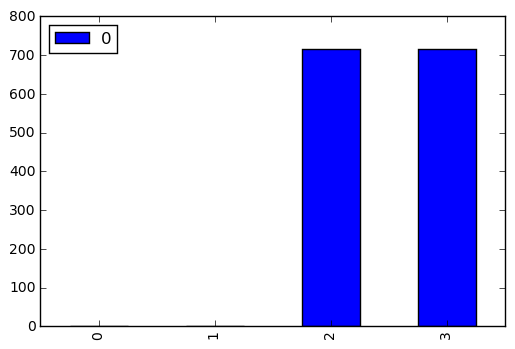

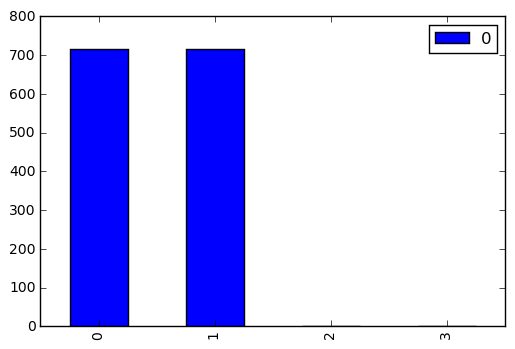

In [12]:
examine_phase(1)

## Plot Schedule

In [13]:
trace = t.get_trace(experiment)

2017-03-06 15:28:03,104 INFO    : Trace        : Platform clusters verified to be Frequency coherent


In [14]:
trappy.plotter.plot_trace(trace.ftrace)

## Plot estimated ideal and estimated power usage

This plot shows how the power estimation for the observed scheduling pattern varies from the estimated power for an ideal schedule.

Where the plotted value for the observed power is higher than the plotted ideal power, the system was wasting power (e.g. a low-intensity task was unnecessarily placed on a high-power CPU). Where the observed value is *lower* than the ideal value, this means the system was *too* efficient (e.g. a high-intensity task was placed on a low-power CPU that could not accomadate its compute requirements).

In [15]:
df = pd.concat([
        expected_power.sum(axis=1), estimated_power.sum(axis=1)], 
               axis=1, keys=['ideal_power', 'observed_power']).fillna(method='ffill')

ILinePlot(df, column=df.columns.tolist(), drawstyle='steps-post').view()

""
""


## Plot CPU frequency

2017-03-06 15:28:05,544 INFO    : Analysis     : LITTLE cluster average frequency: 1.594 GHz
2017-03-06 15:28:05,546 INFO    : Analysis     : big    cluster average frequency: 2.150 GHz


(1.5935999999999999, 2.1504000000000003)

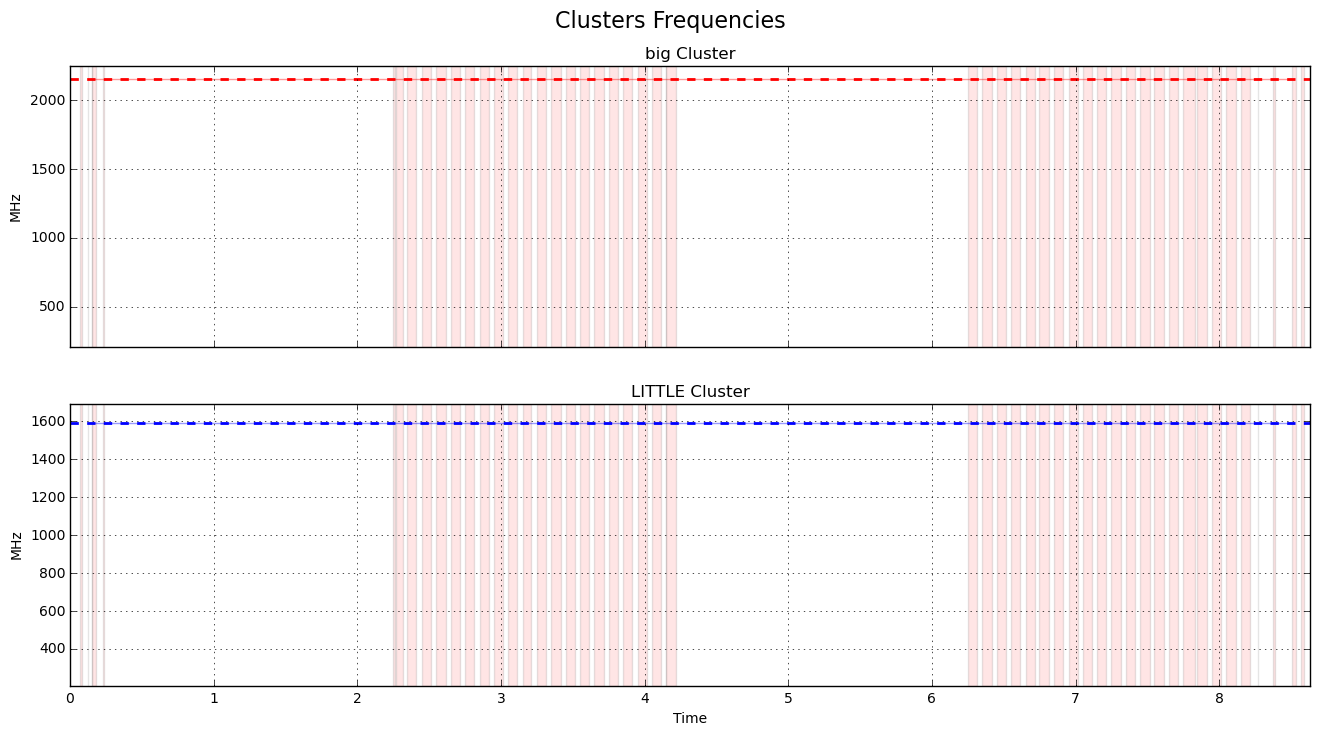

In [16]:
trace.analysis.frequency.plotClusterFrequencies()

## Assertions
These are the assertions used to generate pass/fail results s. They aren't very useful in this interactive context - it's much more interesting to examine plots like the one above and see whether the behaviour was desirable or not. These are intended for automated regression testing. Nonetheless, let's see what the results would be for this run.

`test_slack` checks the "slack" reported by the rt-app workload. If this slack was negative, this means the workload didn't receive enough CPU capacity. In a real system this would represent lacking interactive performance.

In [17]:
try:
    t.test_slack()
except AssertionError as e:
    print "test_slack failed:"
    print e
else:
    print "test_slack passed"

test_slack passed


`test_task_placement` checks that the task placement was energy efficient, taking advantage of lower-power CPUs whenever possible.

In [18]:
try:
    t.test_task_placement()
except AssertionError as e:
    print "test_task_placement failed:"
    print e
else:
    print "test_task_placement passed"

2017-03-06 15:28:08,009 INFO    : Trace        : Platform clusters verified to be Frequency coherent


test_task_placement passed
